### File loading and import

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from google.colab import files
import json
with open("/content/gdrive/My Drive/DL_project/rhyme_classification.json", encoding='latin-1') as file:
    rhymes_dict = json.load(file)

In [ ]:
import numpy as np
from tensorflow.keras.layers import Embedding, Dense, Input, Dropout, TimeDistributed, Flatten, LSTM, Bidirectional, GlobalAveragePooling1D, Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity

### Prepare dataset

In [ ]:
words = []
Y = []
rhyme_idx = dict()
for i,rhyme in enumerate(rhymes_dict):
  rhyme_idx[i] = rhyme
  for word in rhymes_dict[rhyme]:
    words.append(word)
    Y.append(i)

num_rhymes = len(rhymes_dict)
vocab_size = len(words)

tokenizer = Tokenizer(num_words=vocab_size, lower=True, split=' ', char_level=True, oov_token=None)
tokenizer.fit_on_texts(words)
X = pad_sequences(tokenizer.texts_to_sequences(words), padding='pre', value=0)

X = np.array(X)
Y = to_categorical(Y, num_classes=num_rhymes)
print(X.shape)
print(Y.shape)

X, Y = shuffle(X, Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

(13712, 16)
(13712, 1570)


### Plot learning graph

In [ ]:

from keras.callbacks import Callback

from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('categorical_accuracy'))
        self.val_acc.append(logs.get('val_categorical_accuracy'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="categorical accuracy")
        ax2.plot(self.x, self.val_acc, label="val categorical accuracy")
        ax2.legend()

        plt.show();

### Models

#### Embeddings model

In [ ]:
embeddding_size = 30

input = Input(shape=(X_train.shape[1]))
embedding = Embedding(vocab_size, embeddding_size, input_length=X_train.shape[1], mask_zero=True, embeddings_initializer='zeros')(input)
flatten = Flatten()(embedding)
#encoding = Dense(10, kernel_initializer='zeros', kernel_regularizer='l2')(flatten)
#encoding = LSTM(10)(embedding)
dense = Dense(num_rhymes, activation='softmax', kernel_regularizer='l2', trainable=True)(flatten)
dropout = Dropout(0.2)(dense)
model = Model(input, dropout)
print(model.summary())

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 16, 30)            411360    
_________________________________________________________________
flatten_9 (Flatten)          (None, 480)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1570)              755170    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1570)              0         
Total params: 1,166,530
Trainable params: 1,166,530
Non-trainable params: 0
_________________________________________________________________
None


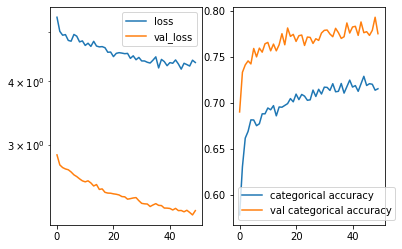

65/65 [==============================] - 3s 41ms/step - loss: 4.3559 - categorical_accuracy: 0.7153 - val_loss: 2.2318 - val_categorical_accuracy: 0.7751


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
es = EarlyStopping(monitor='categorical_accuracy', mode='max', verbose=2, patience=10)
# Start Training
model.fit(X_train, Y_train, batch_size=128, epochs=50, callbacks=[PlotLearning()], validation_split = 0.25, shuffle=True)

In [ ]:
predicted = np.array([np.argmax(p) for p in model.predict(X_test)])
true = np.array([np.argmax(t) for t in Y_test])
accuracy = accuracy_score(true, predicted)
f1score = f1_score(true, predicted, average='macro')
print(accuracy)
print(f1score)

0.7860007291286912
0.4666485023951213


In [ ]:
embedding_model = Model(input, embedding, name="Embedding")
embedding_model.summary()
embedding_model.save("EmbeddingModelRhyme.h5")

Model: "Embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
model_1 (Functional)         (None, 16, 30)            411360    
Total params: 411,360
Trainable params: 411,360
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.models import load_model
embedding_model = load_model("EmbeddingModelRhyme.h5")

#### Encoding model

In [ ]:
encdoding_dimension = 10
input = Input(shape=(X_train.shape[1]), name="Input word")
embedding = embedding_model(input)
flatten = Flatten()(embedding)
#gpa = GlobalAveragePooling1D()(embedding)
encoding = Dense(encdoding_dimension, kernel_initializer='zeros', name="Encoder")(flatten)
dense = Dense(num_rhymes, activation='softmax', kernel_regularizer='l2', trainable=True, name="Rhyme_classifier")(encoding)
dropout = Dropout(0.2)(dense)
model = Model(input, dense)
print(model.summary())

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input word (InputLayer)      [(None, 16)]              0         
_________________________________________________________________
Embedding (Functional)       (None, 16, 30)            411360    
_________________________________________________________________
flatten_10 (Flatten)         (None, 480)               0         
_________________________________________________________________
Encoder (Dense)              (None, 10)                4810      
_________________________________________________________________
Rhyme_classifier (Dense)     (None, 1570)              17270     
Total params: 433,440
Trainable params: 433,440
Non-trainable params: 0
_________________________________________________________________
None


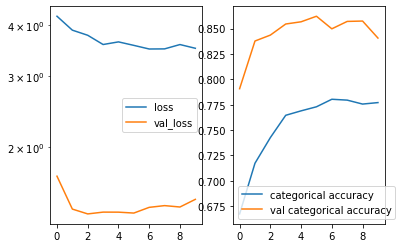

65/65 [==============================] - 1s 22ms/step - loss: 3.5077 - categorical_accuracy: 0.7770 - val_loss: 1.4887 - val_categorical_accuracy: 0.8407


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
es = EarlyStopping(monitor='categorical_accuracy', mode='max', verbose=2, patience=10)
# Start Training
model.fit(X_train, Y_train, batch_size=128, epochs=10, callbacks=[PlotLearning()], validation_split = 0.25, shuffle=True)

In [ ]:
predicted = np.array([np.argmax(p) for p in model.predict(X_test)])
true = np.array([np.argmax(t) for t in Y_test])
accuracy = accuracy_score(true, predicted)
f1score = f1_score(true, predicted, average='macro')
print(accuracy)
print(f1score)

0.8428727670433832
0.572796883125297


In [ ]:
encoding_model = Model(input, encoding)
encoding_model.summary()
encoding_model.save("EncodingModelRhyme100eEmbedding300e.h5")

Model: "functional_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 16)]              0         
_________________________________________________________________
functional_24 (Functional)   (None, 160)               137120    
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1610      
Total params: 138,730
Trainable params: 138,730
Non-trainable params: 0
_________________________________________________________________


### Metrics

In [ ]:
rhyme_scores = {rhyme: cosine_similarity([getEmbeddingVector(word) for word in rhymes_dict[rhyme]]) for i,rhyme in enumerate(rhymes_dict)}

In [ ]:
mean_rhyme_scores = dict()
for rhyme in rhyme_scores:
  mean_rhyme_scores[rhyme] = np.mean(rhyme_scores[rhyme])
scores = np.array([s for s in mean_rhyme_scores.values()])
len(scores[scores>0.5])/len(scores)

0.9509554140127389

In [ ]:
import random

def getEmbeddingVector(word):
  return encoding_model.predict(pad_sequences([tokenizer.texts_to_sequences(word)], maxlen=16, padding='pre', value=0))[0]

def getSimilarity(word1, word2):
  w1 = getEmbeddingVector(word1).reshape(1, 10)
  w2 = getEmbeddingVector(word2).reshape(1, 10)
  return cosine_similarity(w1, w2)[0,0]

def printInfo(scores, rhyme=True):
  TAG = "" if rhyme else "non "
  print("Numero parole testate: ", scores.shape[0])
  print("Media similarità parole "+TAG+"in rima: ", np.mean(scores))
  print("Percentuale parole similarità sopra 0.3: ", len(scores[scores>0.3])/len(scores))

def compare(e1, e2, equal):
  return e1 == e2 if equal else e1 != e2

def getScores(words, words_to_rhymes, rhymes=True, num_words=100):
  scores = []
  for i in range(num_words):
    random1 = random.randint(0,len(words)-1)
    random2 = random.randint(0,len(words)-1)
    while words[random1] not in words_to_rhymes or words[random2] not in words_to_rhymes or (compare(words_to_rhymes[words[random1]],  words_to_rhymes[words[random2]], not rhymes)):
      random1 = random.randint(0,len(words)-1)
      random2 = random.randint(0,len(words)-1)
    w1 = words[random1]
    w2 = words[random2]
    s = getSimilarity(w1, w2)
    scores.append(s)
  return np.array(scores)

In [ ]:
words_to_rhymes = {w:k for k,l in rhymes_dict.items() for w in l}

In [ ]:
scores_rhyme = getScores(words, words_to_rhymes, True)
scores_not_rhyme = getScores(words, words_to_rhymes, False, 1000)

In [ ]:
printInfo(scores_rhyme)
printInfo(scores_not_rhyme, False)

Numero parole testate:  100
Media similarità parole in rima:  0.7391257
Percentuale parole similarità sopra 0.3:  0.88
Numero parole testate:  1000
Media similarità parole non in rima:  -0.009094935
Percentuale parole similarità sopra 0.3:  0.168
